# Part II - Motion Compensation

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Load and display images

Définissons quelques fonctions utiles pour charger et afficher des images.

In [2]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to grayscale
    
    Args:
        path (str): path to image
    Returns:
        np.ndarray: grayscale image
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_images(images: np.ndarray, titles: list=None) -> None:
    """
    Display two images with matplotlib

    Args:
        images (np.ndarray): images to display
        titles (list, optional): titles for images. Defaults to Nones.
    """
    num_imgs = images.shape[0]
    _, axs = plt.subplots((num_imgs // 2) + (num_imgs % 2), 2, figsize=(12, 8))
    if len(axs.shape) < 2:
        axs = np.expand_dims(axs, axis=0)
    for i in range(0, num_imgs, 2):
        for j in range(2):
            if i + j < num_imgs:
                axs[i // 2, j].imshow(images[i + j], cmap='gray')
                if titles is not None:
                    axs[i // 2, j].set_title(titles[i + j])
    plt.show()

Visualisons les données de référence de l'étude.

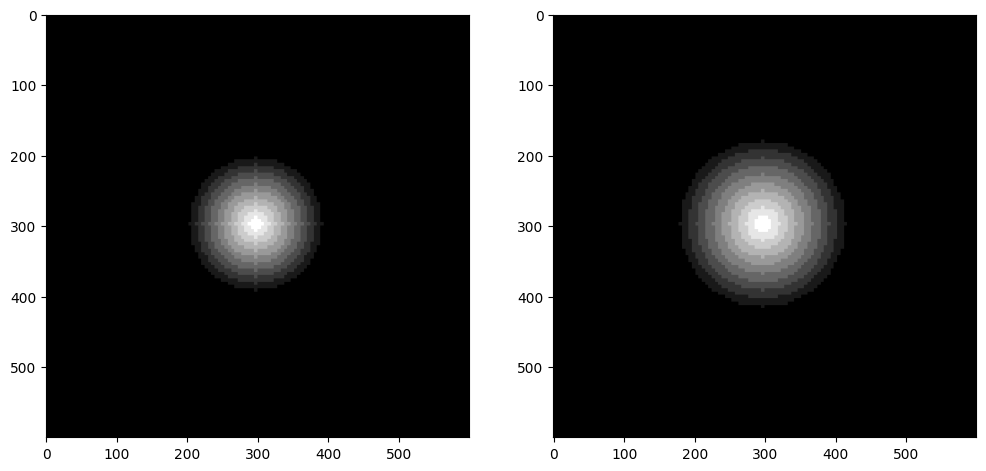

In [3]:
pic1, pic2 = load_image('./images/1.png'), load_image('./images/2.png')
display_images(np.array([pic1, pic2]))

## A - Backward estimation
Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.</br>
<u>Note :</u> c’est désormais F2 que l’on décompose en blocs et non pas F1.

### A.1 - Algorithme de recherche exhaustive (Block Matching Algorithm)

Commencons par définir une fonction nous permettant de calculer localement la différence entre deux images, au voisinig d'un pixel donné, et sur une fenêtre donnée par les positions de ses coins. Nous allons utiliser l'erreur quadratique moyenne (MSE) pour le calcul de l'énergie $E_{dfd}$.

In [4]:
def compute_ideal_motion_vectors_BMA(frame1: np.ndarray, frame2: np.ndarray, block_size: int, window_size: int, current_block: np.ndarray, x: int, y: int) -> tuple[int, int]:
    """
    Compute the ideal motion vectors between two frames
    Args:
        frame1 (np.ndarray): first frame
        frame2 (np.ndarray): second frame
        block_size (int): size of the block
        window_size (int): size of the window
        current_block (np.ndarray): current block
        x (int): x coordinate of the current block
        y (int): y coordinate of the current block
    Returns:
        tuple[int, int]: ideal motion vectors
    """
    i, j = x, y
    E = np.inf
    new_x = 0
    new_y = 0
    dist = np.inf

    # Search in the window
    for k in range(i - window_size, i + window_size):
        for l in range(j - window_size, j + window_size):
            # If the pixel is outside the frame, we skip it
            if k < 0 or k >= frame2.shape[0] or l < 0 or l >= frame2.shape[1]:
                continue
            # Define a new block for the current iteration
            new_block = frame2[k:k+block_size, l:l+block_size]

            # If the new block is not the same size as the current block, we skip it
            if new_block.shape != current_block.shape:
                continue

            # Compute the error between the two blocks
            E_new = np.sum((new_block - current_block) ** 2)

            # If a block is the same in both frames, we can stop the search
            if E_new == 0 and k == i and l == j:
                return (0, 0)
            
            # Compute the distance between the two pixels at position (k, l) and (i, j)
            diff_x = k - i
            diff_y = l - j

            # If the new error minimizes the previous one, we update the error and the motion vectors
            if E_new < E:
                E = E_new
                new_x = diff_x
                new_y = diff_y
            elif E_new == E and (abs(diff_x) + abs(diff_y)) < dist:
                dist = abs(diff_x) + abs(diff_y)
                new_x = diff_x
                new_y = diff_y
            
    return new_x, new_y

A présent, nous allons parcourir de manière naïve tous les pixels de l'image, et pour chacun d'entre eux, estimer le mouvement en calculant l'énergie $E_{dfd}$ pour chaque vecteur de mouvement possible. Nous allons ensuite choisir le vecteur de mouvement minimisant $E_{dfd}$.

In [5]:
def BMA(frame1: np.ndarray , frame2: np.ndarray, block_size: int = 16, window_size: int = 7) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm

    Args:
        frame1 (np.ndarray): first frame
        frame2 (np.ndarray): second frame
        block_size (int, optional): size of the block. Defaults to 16.
        window_size (int, optional): size of the window. Defaults to 7.
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape

    # Normalize frames
    frame1 = frame1 / 255
    frame2 = frame2 / 255
    
    # Initialize motion vectors
    v_x = []
    v_y = []

    moving_blocks_x = []
    moving_blocks_y = []

    for i in tqdm(range(0, frame_shape[0], block_size)):
        for j in range(0, frame_shape[1], block_size):
            # Get the current block
            current_block = frame1[i:i+block_size, j:j+block_size]

            # Compute the motion vectors for the current block
            motion_vectors = compute_ideal_motion_vectors_BMA(frame1, frame2, block_size, window_size, current_block, i, j)

            v_x.append(motion_vectors[0])
            v_y.append(motion_vectors[1])
            moving_blocks_x.append(i)
            moving_blocks_y.append(j)
    
    return np.array(v_x), np.array(v_y), np.array(moving_blocks_x), np.array(moving_blocks_y)

### A.2 - Résultats

Nous pouvons à présent chercher à visualiser les vecteurs de mouvement estimés. On se propose d'écrire une fonction calculant le champs de vecteurs de mouvments, puis qui les afficher sur l'image de référence.

In [6]:
def BMA_display(frame1: np.ndarray, frame2: np.ndarray, block_size: int = 16, window_size: int = 10, scale: int = 500) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm and display the results.
    A quiver plot is used to display the motion vectors.
    Args:
        frame1: first frame
        frame2: second frame
        block_size: size of a block
        window_size: size of the window
        scale: scale of the quiver plot
    Returns:
        v_x: x component of the motion vectors
        v_y: y component of the motion vectors
        moving_blocks_x: x coordinates of the moving blocks
        moving_blocks_y: y coordinates of the moving blocks
    """
    v_x , v_y, moving_blocks_x, moving_blocks_y = BMA(frame1, frame2, block_size=block_size, window_size=window_size)
    _, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(frame1, cmap='gray')
    ax.set_axis_off()
    ax.set_title(f'Backward Motion Estimation (Block size: {block_size})')

    ax.quiver((moving_blocks_x + block_size // 2),
              (moving_blocks_y + block_size // 2),
              v_x,
              -v_y,
              scale=scale,
              color='red',
              headwidth=2,
              headlength=2,
              width=0.003)
    
    plt.show()

    return v_x, v_y, moving_blocks_x, moving_blocks_y

On peut à présent visualiser les vecteurs de mouvement estimés, en définissant la taille de block et la taille de la fenêtre de recherche.

  0%|          | 0/15 [00:00<?, ?it/s]

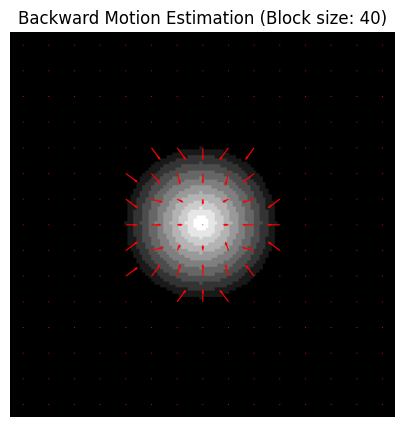

In [7]:
# Define parameters (block size and window size)
BLOCK_SIZE = 40
WINDOW_SIZE = 20

# Use pic2 as first frame, that will decomposed into blocks
# Use pic1 as second frame, that will be used to find the best match for each block
v_x, v_y, moving_blocks_x, moving_blocks_y = BMA_display(pic2, pic1, block_size=BLOCK_SIZE, window_size=WINDOW_SIZE, scale=600)

### B - Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)


### C - Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

Afin d'éviter une duplication de code, on définit une fonction qui reconstruit une image à partir d'une image de référence et d'un champ de vecteurs de mouvement.

In [8]:
def reconstruct_frame(frame1: np.ndarray, frame2: np.ndarray, block_size: int, v_x: np.ndarray, v_y: np.ndarray, moving_blocks_x: np.ndarray, moving_blocks_y: np.ndarray) -> np.ndarray:
    """
    Reconstruct a frame using the motion vectors and the moving blocks

    Args:
        frame1 (np.ndarray): first frame
        frame2 (np.ndarray): second frame
        block_size (int): size of the blocks
        v_x (np.ndarray): x component of the motion vectors
        v_y (np.ndarray): y component of the motion vectors
        moving_blocks_x (np.ndarray): x coordinates of the moving blocks
        moving_blocks_y (np.ndarray): y coordinates of the moving blocks

    Returns:
        np.ndarray: reconstructed frame
    """
    frame_shape = frame1.shape
    frame2_reconstructed = np.zeros(frame_shape)
    
    for i in range(len(moving_blocks_x)):
        x = moving_blocks_x[i]
        y = moving_blocks_y[i]
        frame2_reconstructed[x:x+block_size, y:y+block_size] = frame1[x+v_x[i]:x+v_x[i]+block_size, y+v_y[i]:y+v_y[i]+block_size]

    return frame2_reconstructed

Nous pouvons maintenant l'utiliser pour reconstruire F2 à partir de F1 et des vecteurs de mouvement.

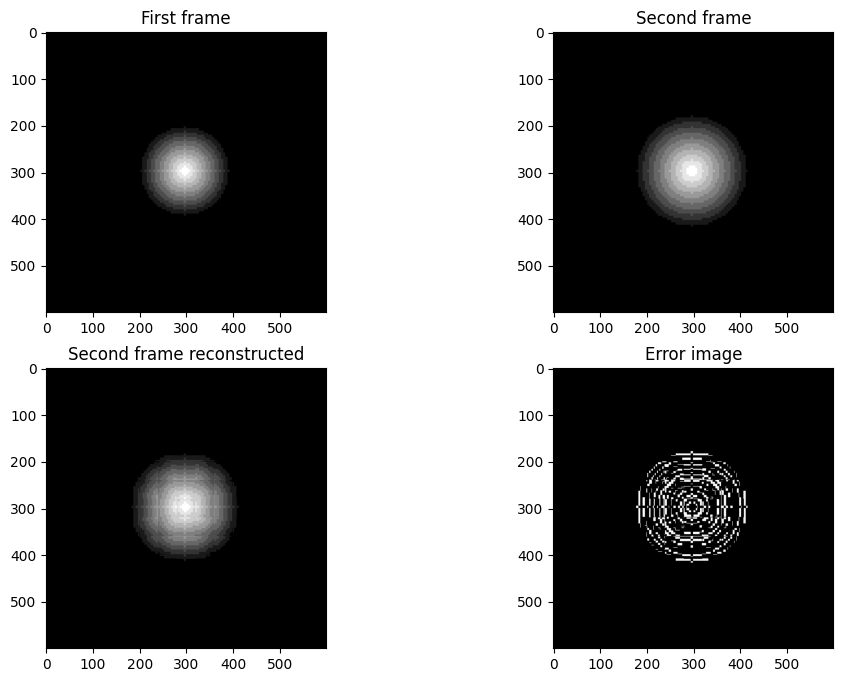

Reconstruction accuracy: 97.05%
Parameters -> block size: 40, window size: 20

Reconstruction Mean Squared Error: 19.18


In [9]:
# Reconstruct the frame
pic2_reconstructed = reconstruct_frame(pic1, pic2, BLOCK_SIZE, v_x, v_y, moving_blocks_x, moving_blocks_y)
# Compute the error image
error_image = np.abs(pic2 - pic2_reconstructed)

# Display the reconstructed frame
display_images(images=np.array([pic1, pic2, pic2_reconstructed, error_image]),
               titles=['First frame', 'Second frame', 'Second frame reconstructed', 'Error image'])

# Percentage of pixels that are the same in both frames
print(f'Reconstruction accuracy: {np.sum(np.abs(pic2 - pic2_reconstructed) < 1e-6) / (pic2.shape[0] ** 2) * 100:.2f}%')
print(f'Parameters -> block size: {BLOCK_SIZE}, window size: {WINDOW_SIZE}\n')

print(f'Reconstruction Mean Squared Error: {np.sum(np.square(pic2 - pic2_reconstructed)) / (pic2.shape[0] ** 2):.2f}')

Nous pouvons observer que la reconstruction de la deuxième image **F2** avec l'**estimation de mouvement** et l'image source **F1** entraîne une perte conséquente d'informations. Cela est également démontré par une **erreur quadratique moyenne élevée (MSE)**.

Cependant, il est important de souligner que la taille des blocs et la taille de la fenêtre de recherche peuvent affecter l'image résultante. Voici un exemple dans lequel nous sommes en mesure de reconstruire parfaitement la deuxième image.

  0%|          | 0/120 [00:00<?, ?it/s]

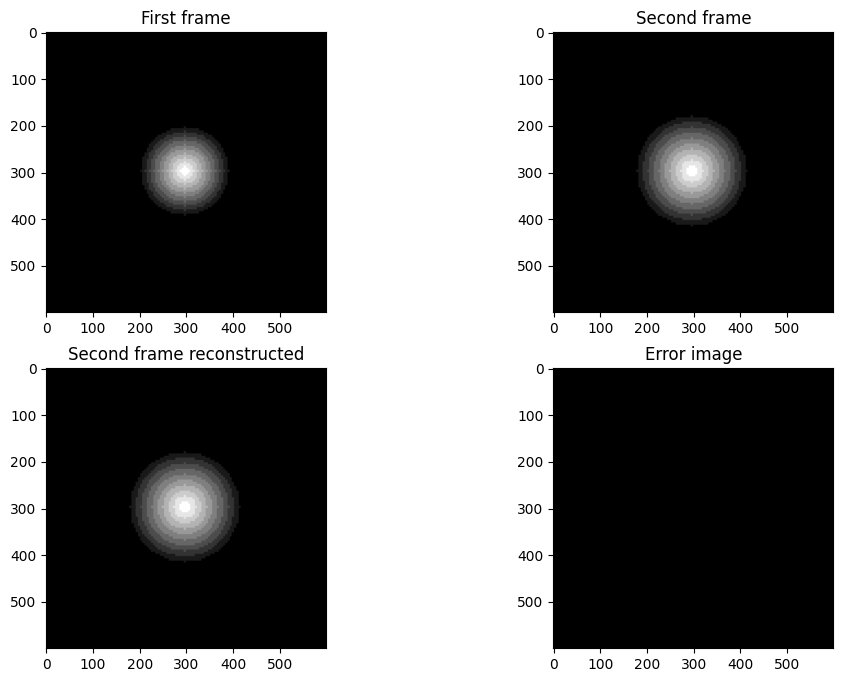

Reconstruction accuracy: 100.00%
Parameters -> block size: 5, window size: 25

Reconstruction Mean Squared Error: 0.00


In [10]:
NEW_BLOCK_SIZE = 5
NEW_WINDOW_SIZE = 25

v_x, v_y, moving_blocks_x, moving_blocks_y = BMA(pic2, pic1, block_size=NEW_BLOCK_SIZE, window_size=NEW_WINDOW_SIZE)

# Reconstruct the frame
pic2_reconstructed = reconstruct_frame(pic1, pic2, NEW_BLOCK_SIZE, v_x, v_y, moving_blocks_x, moving_blocks_y)
# Compute the error image
error_image = np.abs(pic2 - pic2_reconstructed)

# Display the reconstructed frame
display_images(images=np.array([pic1, pic2, pic2_reconstructed, error_image]),
               titles=['First frame', 'Second frame', 'Second frame reconstructed', 'Error image'])

# Percentage of pixels that are the same in both frames
print(f'Reconstruction accuracy: {np.sum(np.abs(pic2 - pic2_reconstructed) < 1e-6) / (pic2.shape[0] ** 2) * 100:.2f}%')
print(f'Parameters -> block size: {NEW_BLOCK_SIZE}, window size: {NEW_WINDOW_SIZE}\n')

print(f'Reconstruction Mean Squared Error: {np.sum(np.square(pic2 - pic2_reconstructed)) / (pic2.shape[0] ** 2):.2f}')

À partir de ces deux exemples, nous pouvons observer une tendance de variation de l'exactitude de la reconstruction et de l'erreur quadratique moyenne (MSE). En effet, avec une taille de bloc assez petite et une taille de fenêtre beaucoup plus grande, l'exactitude de la reconstruction des images tend à être plus élevée.

### D - Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

### E - Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

### F - Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

### G - Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? Et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.